# Final Tutorial CVE 
### Sushant Tamrakar

## Introduction
The motivation for this project came from my reading of the article by Motherboard, titled The Internet Has A Huge C/C++ Problem and Developers Don't Want to Deal With It[0]. In this article, the Rust developer Alex Gaynor, argues that bugs like Heartbleed and WannaCry are due to memory unsafety in the language itself. He promotes Rust as a viable memory safe language to possibly replace programs written in C/C++. He reasons why memory unsafety is still prevalent when we have language like Swift and Rust. He mentions the cost of change and the plethora of already written libraries that are faced with transition cost. However, he notes that developers ignore the problem of safety largely, arguing that people should just code better. In this project, I would like to look more into Alex's claims of Memory Unsafety error, largely Buffer Overflow, which seems to be a large case of vulnerabilites according to him. Furthermore, we would also like to see what other vulnerabilites are more common in C/C++

In [10]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

Lets's gather the data from the csv. The cve_data.csv contains all the vulnerabilities from NVD's data feeds. It consists the vulnerabilties from year early 1990s to December 2018. The cwelist.csv is the list of CWE categories with their description name. We need this table as the cve_data.csv scraped from NVD's data feeds only lists CWE-IDs and not the actual description of them. Thus we are joining the table to make a understandable final table

In [2]:
cve_data = pd.DataFrame.from_csv('cve_data.csv')
cwe_list = pd.DataFrame.from_csv('cwelist.csv')
cwe_list = cwe_list.rename(columns={'CWE':'Name','CWE-ID':'CWE_Description'})
cwe_list = cwe_list.drop('Description',axis=1)
cve_data = cve_data.join(cwe_list,on='CWE')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


Full Discretion: I initially wrote the scrape_data.py script in here in jupyter. However, it refused to work for more than 3 or 4 files in the loop. I think this is possibly due to some open file limit on jupyter running on docker. Therefore, I wrote the script separately and ran it to produce the corresponding csv that I have used here. Please look at the scrape_data.py for how data scraping was done from the NIST website as well as CWE data

In [203]:
cve_data.head()

,CVE_ID,CWE,accessVector,accessComplexity,authentication,confidentialityImpact,integrityImpact,availabilityImpact,baseScore,severity,exploitabilityScore,impactScore,publishedDate,lastModifiedDate,CWE_Description,Year
0,CVE-1999-0001,CWE-20,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,5.0,MEDIUM,10.0,2.9,1999-12-30T05:00Z,2010-12-16T05:00Z,Input Validation,1999
1,CVE-1999-0002,CWE-119,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,1998-10-12T04:00Z,2009-01-26T05:00Z,Buffer Errors,1998
2,CVE-1999-0003,NVD-CWE-Other,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,1998-04-01T05:00Z,2018-10-30T16:26Z,Other,1998
3,CVE-1999-0004,NVD-CWE-Other,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,5.0,MEDIUM,10.0,2.9,1997-12-16T05:00Z,2018-10-12T21:29Z,Other,1997
4,CVE-1999-0005,NVD-CWE-Other,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,1998-07-20T04:00Z,2008-09-09T12:33Z,Other,1998


## Exploratory Data Analysis

Before we go to look at Memory related vulnerabilities, lets look at the frequency of vulnerabilities over the years

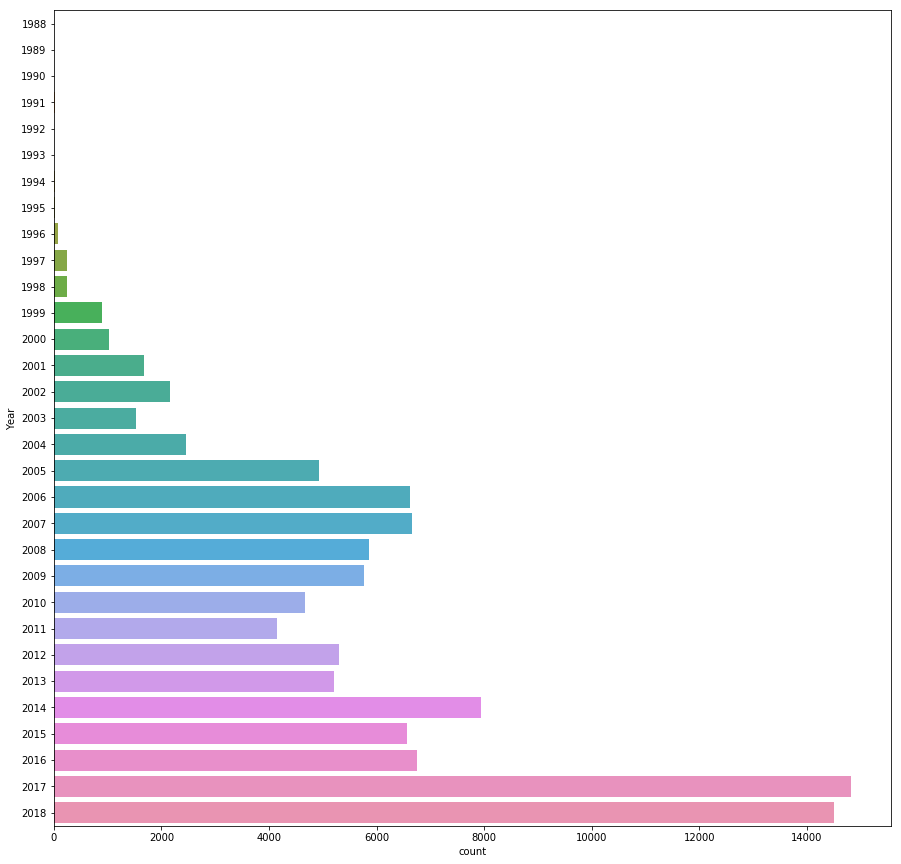

In [3]:
# Extact the years from the publishedDate
cve_data['Year']=cve_data['publishedDate'].str[:4]
# plot by the years
g = sns.countplot(y=cve_data['Year'])
g.figure.set_size_inches(15,15)
# expecting general trend upward but not really. Dips and Spikes is sort of common

It's understandable that the frequency is low around the beginning as much of metric and categorization system for vulnerabilities weren't established. Furthermore, we can see a peak as we move from 2004 to 2005, as we further progress in software development. It's interesting to note that the it seems to be have stabilized around the mid 2000s with 2006 and 2007 having similar number of reported vulnerabilities. And we keep going down into 2010s. There is a definite huge spike in 2017, possibly due to numerous bugs that came out that year. Let's take a look how C/C++ commonly associated bugs fared along the years. Most of the C/C++ bugs that are categorized as taken from CWE's view itself. Most of the vulnerabilites they identify as C/C++ vulnerabilites are memory unsafety errors.

### Importing lists of common CWE IDs associated with C/C++

In [4]:
# Data downloaded from https://cwe.mitre.org/data/definitions/659.html
# and https://cwe.mitre.org/data/definitions/658.html
# Cleaned using regular text editor to remove unnecessary columns.
cwe_c = pd.DataFrame.from_csv('cwe_c.csv')
cwe_cpp = pd.DataFrame.from_csv('cwe_cpp.csv')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """


In [5]:
# joining the CWE from C and CWE from Cplusplus
result = pd.merge(cwe_c, cwe_cpp, how='outer', on=['ID'])
result = result.reset_index()
result

,ID,Name_x,Name_y
0,119,Improper Restriction of Operations within the ...,Improper Restriction of Operations within the ...
1,120,Buffer Copy without Checking Size of Input ('C...,Buffer Copy without Checking Size of Input ('C...
2,121,Stack-based Buffer Overflow,Stack-based Buffer Overflow
3,122,Heap-based Buffer Overflow,Heap-based Buffer Overflow
4,123,Write-what-where Condition,Write-what-where Condition
5,124,Buffer Underwrite ('Buffer Underflow'),Buffer Underwrite ('Buffer Underflow')
6,125,Out-of-bounds Read,Out-of-bounds Read
7,126,Buffer Over-read,Buffer Over-read
8,127,Buffer Under-read,Buffer Under-read
9,128,Wrap-around Error,Wrap-around Error


As we can see from some of the CWE categories above, most of them fall under memory unsafety, such as Buffer Overflow, unchecked return value, free after use, etc. Going futher, lets look at the frequency of these C/C++ errors possibly the trend over the years of these vulnerabilities

In [6]:
# Honestly we only care about IDs as we already have 
c_cpp_cwe = result['ID'].astype(str)

In [11]:
# get only the rows where c and cpp cwe are relevant from the cve_data pile
c_cpp_data = cve_data.loc[cve_data['CWE'].str[4:].isin(c_cpp_cwe)]


Let's do a quick frequency plot which category of CWE were reported the most for C/C++

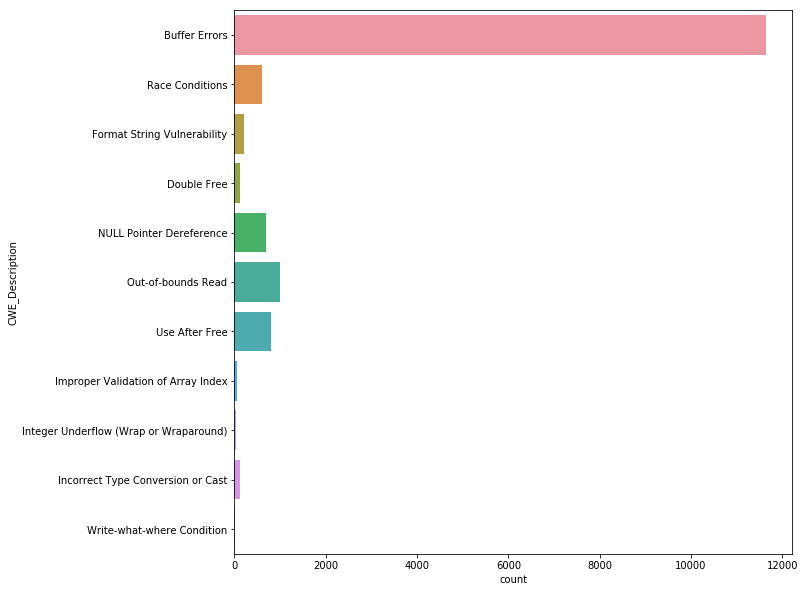

In [12]:
p = sns.countplot(y="CWE_Description", data=c_cpp_data)
p.figure.set_size_inches(10,10)

Now this is interesting, we have an alarmingly large number of error related to buffer overflow over all these years, followed by Out-of-bound Read and others. This is also interesting as out of all the C/C++ categories we had (about 100 some), we only see these couple vulnerabilities reported the most. We can see why Alex had the opinions he had formed as one can argue that bugs like buffer errors, out-of-bounds read, null pointer dereference and such are almost always taken care of in memory-safe languages. However, let's look at the trend of these categories of vulnerabilities as they are pretty interesting ones outside of the bugs related to Web.

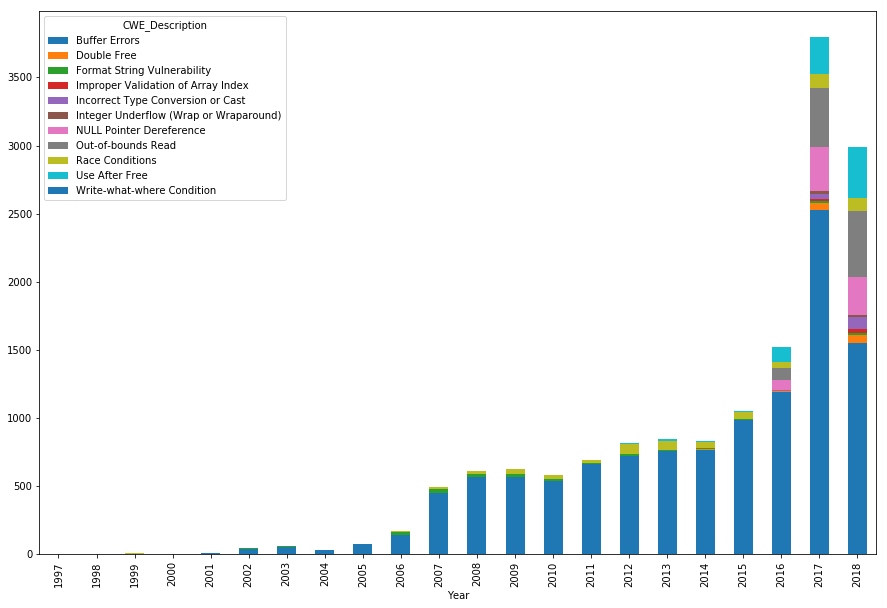

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
c_cpp_data.groupby(['Year','CWE_Description']).count()['CWE'].unstack().plot(kind='bar',stacked=True,ax=ax)

Buffer Errors as we expected are majority of the culprit on the rise as the years go by. However, we also see memory unsafety errors like use after free and out of bounds read to be rising as well. 2017 seems to have been a big year for vulnerabilities, possibly due to vulnerabilities like WannaCry. Buffer errors seem to be reported lower in 2018 even though vulnerabilites like Spectre were out this year. However, Use after free and Out of bounds Read error did increase in 2018 a bit.

## Over the years has the average baseScore risen in general and among C/C++ vulnerabilities?

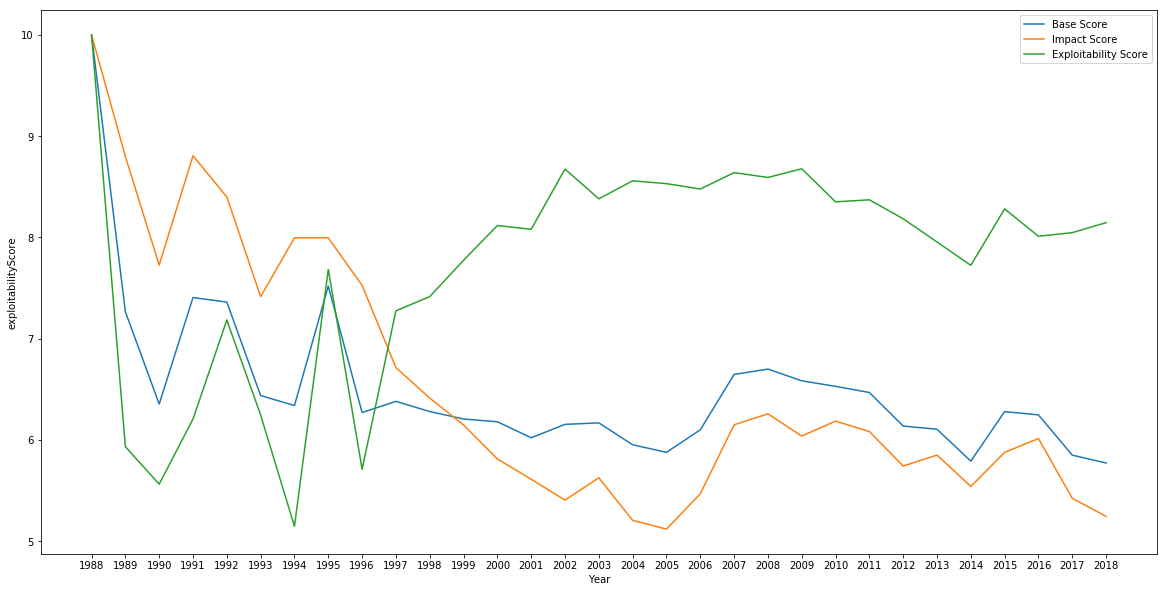

In [29]:
avg_cve_score = cve_data.groupby('Year').mean().reset_index()
p = sns.lineplot(x=avg_cve_score['Year'],y=avg_cve_score['baseScore'],label='Base Score')
p = sns.lineplot(x=avg_cve_score['Year'],y=avg_cve_score['impactScore'], label = 'Impact Score')
p = sns.lineplot(x=avg_cve_score['Year'],y=avg_cve_score['exploitabilityScore'], label = 'Exploitability Score')

p.figure.set_size_inches(20,10)

It makes sense for baseScore and impactScore to follow as baseScore combines impactScore and exploitabiityScore. However, it weighs impactScore heavily in V2 metric system of CVSS. It is quite interesting to see however, that over the years, exploitabilityScore has risen. ExploitabilityScore accounts for Access Vector, Access Complexity along with Authentication in V2 metric calculation system. Exploitability score hints us how easily attackable these vulnerabilities are. However, looking at the formula given by [CVSS](https://www.first.org/cvss/v2/guide), we can conclude that the impact score is driving the base score here. Impact score is driven impact categories: ConfidentialityImpact, AvailabilityImpact, IntegrityImpact. Since this is the entire dataset, the category of CWE-OTHERS could be showing the trend downwards. Let's look at specifically the categories of CVE that are related to C/C++ (Memory related)

[Text(0,0.5,'Scores')]

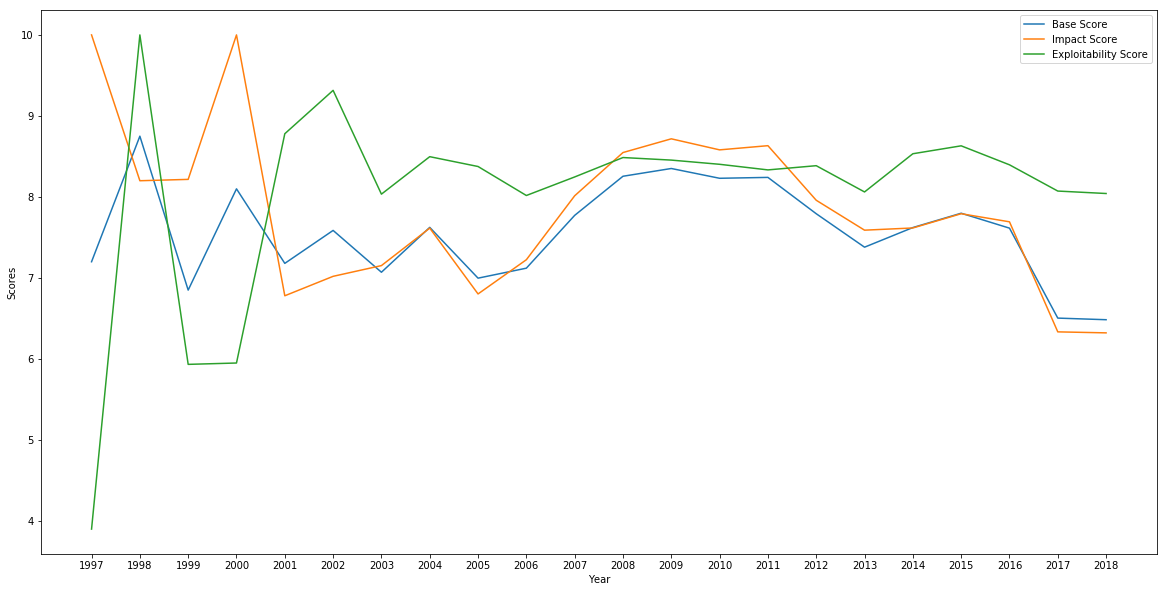

In [77]:
avg_cve_score_cpp= c_cpp_data.groupby('Year').mean().reset_index()
p = sns.lineplot(x=avg_cve_score_cpp['Year'],y=avg_cve_score_cpp['baseScore'],label='Base Score')
p = sns.lineplot(x=avg_cve_score_cpp['Year'],y=avg_cve_score_cpp['impactScore'], label = 'Impact Score')
p = sns.lineplot(x=avg_cve_score_cpp['Year'],y=avg_cve_score_cpp['exploitabilityScore'], label = 'Exploitability Score')

p.figure.set_size_inches(20,10)
p.set(ylabel='Scores')



Here we can see that all the scores follow a similar trend. Exploitability score has stabilized over the years for memory related errors. However, it is still considered high as it is above 7. Over the recent years, while the memory related bugs have exploded, their impact is Medium while their Exploitability being High. These vulnerabilities include WannaCry[[BaseScore: High]](https://nvd.nist.gov/vuln/detail/CVE-2017-8620), HeartBleed[[BaseScore: Medium]](https://nvd.nist.gov/vuln/detail/CVE-2014-0160) and Spectre[[BaseScore: High]](https://nvd.nist.gov/vuln/detail/CVE-2017-5753)related vulnerabilities that we saw over few years recently.

## Scores over the Years By CWE Description for C/C++ Vulnerabilities

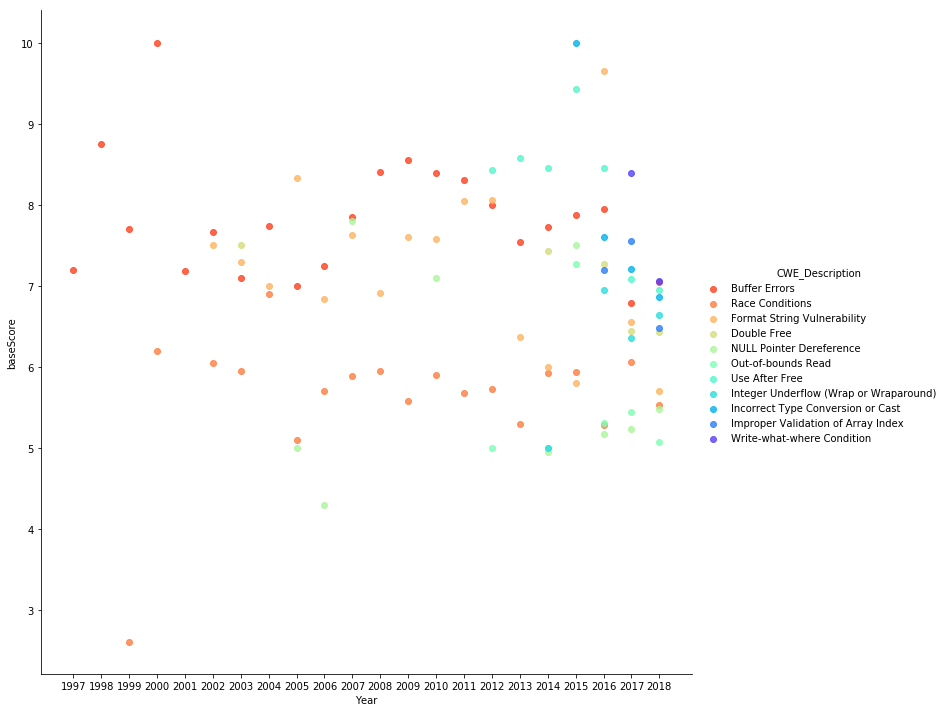

In [88]:
sns.lmplot('Year', 'baseScore', fit_reg = False, hue='CWE_Description', 
           data=c_cpp_data.groupby(['Year','CWE_Description']).mean().reset_index().sort_values(by='Year'), 
           height = 10, palette ='rainbow_r')


We can see that almost every year, buffer errors receive a high score on average while Race Conditions usually are classified as a medium. Since 2013 to 2017. Buffer errors have had a trend of average high base score. To understand this a bit more. Lets also plot these for impact and exploitability scores

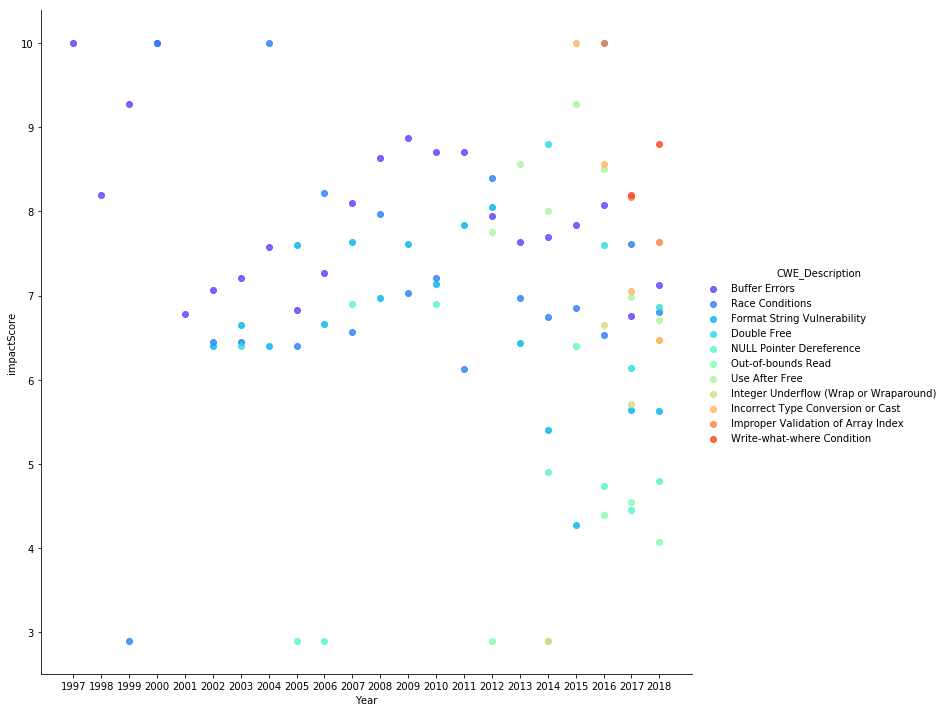

In [90]:
sns.lmplot('Year', 'impactScore', fit_reg = False, hue='CWE_Description', 
           data=c_cpp_data.groupby(['Year','CWE_Description']).mean().reset_index().sort_values(by='Year'), 
           height = 10, palette='rainbow')


The trend of average impactScore follows the same as base score for buffer errors. However, we can see that Write-what-where condition was reigned on a high impact score in 2018. We can also notice that out of bounds and use after free vulnerabilities' impact has increased on average over the years

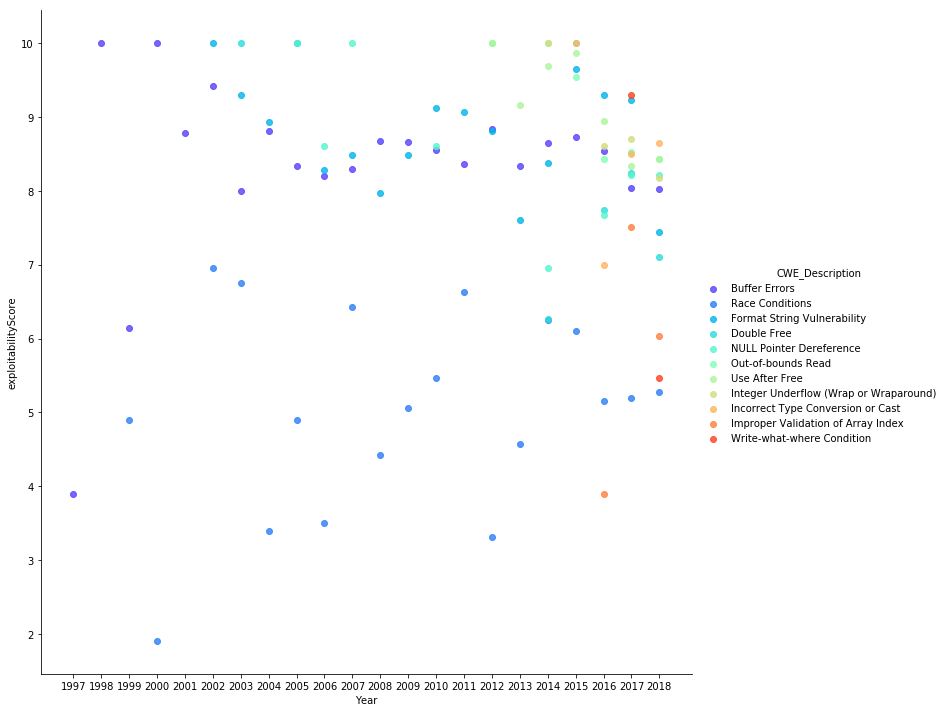

In [91]:
sns.lmplot('Year', 'exploitabilityScore', fit_reg = False, hue='CWE_Description', 
           data=c_cpp_data.groupby(['Year','CWE_Description']).mean().reset_index().sort_values(by='Year'), 
           height = 10, palette='rainbow')

Here we notice that buffer errors are still highly exploitable. This also means that the accessComplexity for them is low once gained access from the access Vector. We also notice that user after free vulnerabilites have increased in exploitablity over the years

We can also notice that vulnerabilities are on the rise with the advent of Internet but just how much of C/C++ vulnerabilties can we attribute to Internet than local use. For this, I will be looking at the categories of accessVector provided by CVSS's version 2 metric system. It is to note that I am using version 2 instead of version 3 as version 3, while robust, is fairly new metric that isn't quantified to plethora of older vulnerabilities prior to 2016. With that out of the way, let's look what Access Vector is used for most of these memory attack. Access vectors are of three categories: Local, Network or Adjacent Network and they define how a vulnerability can be exploited.